# Automatic Seismic to Well Tie

#### Import packages

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import yaml

from wtie import grid, autotie, viz
from wtie.utils.datasets import tutorial

from pprint import pprint

import matplotlib.pyplot as plt

# uncomment if your browser supports it
#%matplotlib notebook 

### Import data


In this tutorial we work on data from the Well *Torosa1* of the open [Poseidon](https://terranubis.com/datainfo/NW-Shelf-Australia-Poseidon-3D) dataset. Data is saved in the folder **data/tutorial**.

In [2]:
# data path
folder = Path('../data/tutorial')
assert folder.exists()

inputs = tutorial.load_poseidon_data(folder, well='torosa1')

### Load pretrained network to extract the wavelet

In [3]:
# neural network's weights
model_state_dict = folder / 'trained_net_state_dict.pt'
assert model_state_dict.is_file()

# network training paramters
with open(folder / 'network_parameters.yaml', 'r') as yaml_file:
    training_parameters = yaml.load(yaml_file, Loader=yaml.Loader)
    
wavelet_extractor = tutorial.load_wavelet_extractor(training_parameters, model_state_dict)

Loading network parameters from ../data/tutorial/trained_net_state_dict.pt


### Load synthetic modeling tool

In [4]:
modeler = tutorial.get_modeling_tool()

### Parameters for the search

In [5]:
print(autotie.tie_v1.__doc__)


    Utility to perform automatic (prestack) seismic to well tie. This version 1
    serves as a base recipe. Feel free to implement your own recipe using the
    various tools of the package.

    Parameters
    ----------
    inputs : _tie.InputSet
        Necessary inputs for the well tie.
    wavelet_extractor : wtie.learning.model.BaseEvaluator
        Object to extract a wavelet using the provided neural network.
    modeler : wtie.modeling.modeling.ModelingCallable
        Synthetic modeling tool.
    wavelet_scaling_params : dict
        Parameters for the search of the optimal absolute wavelet sacle.
        3 parameters: 'wavelet_min_scale' and 'wavelet_max_scale' are the search
        bounds. 'num_iters' (optional) is the total number of iterations for the
        search.
    search_space : dict, optional
        Bounds of the search space. See `get_default_search_space_v1`.
    search_params : dict, optional
        Dict with 3 parameters for the Bayesian search. 'num_iter

#### Define the tie parameters search space (optional)

So far, supported parameters correspond to the log filtering and depth to time table bulk shift. See the `tie.get_default_search_space_v1` docstring.

In [6]:
print(autotie.get_default_search_space_v1.__doc__)


    Search space of version 1 is composed of 4 parameters:
        - "logs_median_size" : size (in number of samples) of the median filter window.
        - "logs_median_threshold" : threshold value with respect to the logs standard deviation.
        - "logs_std" : standard deviation of the gaussian smoothing filter.
        - "table_t_shift" : bulk shift in seconds of the depth-time relation table.

    Parameters are defined following the [Ax](https://github.com/facebook/Ax)
    documentation.


In [7]:

# Logs processing
median_length_choice = dict(name="logs_median_size", type="choice",
                  values=[i for i in range(11,63,2)], value_type="int")

median_th_choice = dict(name="logs_median_threshold", type="range",
                  bounds=[0.1, 5.5], value_type="float")

std_choice = dict(name="logs_std", type="range",
                  bounds=[0.5, 5.5], value_type="float")


# bulk shift in seconds
table_t_shift_choice = dict(name="table_t_shift", type="range",
                  bounds=[-0.012, 0.012], value_type="float")


search_space = [median_length_choice,
                median_th_choice,
                std_choice,
                table_t_shift_choice
                ]

#### Bayesian search parameters (optional)

In [8]:
search_params = dict(num_iters=80, similarity_std=0.02)

#### Wavelet absolute amplitude search params

In [9]:
wavelet_scaling_params = dict(wavelet_min_scale=50000, wavelet_max_scale=500000, num_iters=60)

### Optimization

In [10]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


outputs = autotie.tie_v1(inputs,
                         wavelet_extractor,
                         modeler,
                         wavelet_scaling_params,
                         search_params=search_params,
                         search_space=search_space,
                         stretch_and_squeeze_params=None) 

stage 0
Tensor Details:
- Size: torch.Size([32])
- Device: cpu
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([32])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([64])
- Device: cpu
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([64])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([128])
- Device: cpu
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([128])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([32])
- Device: cpu
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([32])
- Device: cpu
- Type:

 12%|█▎        | 10/80 [00:00<00:01, 43.84it/s]

upper
[3555.96776252 3618.87821371 3728.75353908 3483.25814645 3385.56181593
 3509.45960546 3571.51963529 3586.22474905 3543.5671138  3497.31555879
 3475.98929091 3470.46136044 3423.57151601 3453.09152648 3570.99368092
 4013.7575864  4496.09195799 4527.29400005 4715.39239388 4827.62675326
 4604.61157524 4322.36228446 4083.40503264 4098.04308621 4099.4896145
 4068.6979296  3952.3648298  3815.54105061 3941.22807827 4016.37672031
 3852.21280521 3841.18831867 4052.56296217 4117.09364253 4171.13786449
 4082.79966882 3802.39238508 3815.91872099 3797.88867843 3799.99678886
 3858.76837459 3572.1726105  3545.95046585 3704.47424242 3489.97370243
 3437.25250828 3503.85190244 3275.02017378 3194.22724202 3259.84025662
 3232.54518899 3167.27689876 3156.35322561 3404.06622857 3559.87549528
 3564.64623558 3649.85245662 3649.66753712 3675.90323391 3672.63041827
 3679.6071088  3717.94505207 3633.81850471 3643.18275882 3616.48548729
 3523.4673772  3552.97137045 3581.53992548 3547.42752921 3552.73575242
 

 25%|██▌       | 20/80 [00:00<00:01, 45.21it/s]

upper
[3558.76575762 3620.59325892 3720.26785625 3486.66967497 3388.68762261
 3508.3611504  3570.09353334 3585.12970453 3543.76300576 3497.13122211
 3477.60251255 3467.2578919  3427.33154559 3452.64313031 3579.70971372
 4014.43833528 4485.10527574 4596.27339344 4773.58102168 4818.08911068
 4605.86477082 4323.19859112 4086.17869031 4098.94878699 4097.29074544
 4068.5577039  3950.44523109 3821.11313994 3940.60161694 4010.66566896
 3856.0629633  3845.33070328 4049.07240836 4117.58141305 4168.93943217
 4078.61632544 3809.10566441 3814.28650814 3797.98891894 3802.60023693
 3849.68966692 3577.87042622 3551.22800157 3694.23167452 3494.59813802
 3440.74121662 3494.88311247 3279.80198097 3197.7333102  3256.99346785
 3231.68250292 3167.88889412 3164.65062664 3400.86209997 3555.24427392
 3567.90239639 3646.87022467 3650.95544737 3674.96529822 3672.64891423
 3680.95736514 3714.35961353 3636.67708519 3642.05924907 3614.70301512
 3526.66803219 3552.63922271 3579.98898975 3548.24937856 3554.50689921


 38%|███▊      | 30/80 [00:00<00:01, 46.92it/s]

upper
[3586.99369704 3627.07081294 3646.00549231 3513.93330255 3437.0101903
 3496.42679785 3556.73799606 3570.08768066 3542.40660293 3503.85265394
 3479.25635311 3462.82975872 3442.86408704 3489.16718805 3654.60396162
 4016.91098018 4397.77409388 4557.61370132 4702.5479314  4766.91663293
 4593.53401006 4330.74155695 4134.73553645 4095.29911724 4093.47566616
 4049.41076052 3948.83687163 3873.43647721 3931.43877057 3963.17700225
 3887.56301781 3892.94848884 4019.97566067 4113.42751859 4140.62442869
 4042.21077753 3866.93012556 3810.27619453 3802.86821305 3810.37967688
 3779.1428527  3632.79144142 3591.68189463 3615.86964161 3526.89595928
 3465.57623305 3429.30553092 3312.70265986 3236.50749535 3236.85864724
 3219.90588378 3191.06459063 3233.89003772 3379.47267934 3514.8165787
 3582.38841058 3628.90039272 3654.8868181  3669.08870849 3674.72687256
 3686.49314597 3688.8839316  3655.13638717 3634.25912018 3601.29355274
 3553.82514864 3553.64285379 3566.05068878 3557.54982184 3569.9598782
 36

 44%|████▍     | 35/80 [00:00<00:00, 46.47it/s]

upper
[3534.34129972 3597.04549486 3799.05933967 3463.2311154  3365.99433698
 3524.68501129 3571.68717415 3599.25978642 3540.39272057 3494.22313537
 3473.00175729 3477.45451524 3414.3564295  3441.96371378 3520.28703086
 4010.01664225 4563.29360376 4489.5006947  4731.56410825 4863.60686477
 4602.41142011 4322.02434945 4045.68574064 4111.72458038 4096.53925617
 4078.59189179 3964.39517775 3774.76949834 3946.78871187 4060.56971273
 3826.89803362 3801.52091753 4087.34641821 4107.02052234 4184.14719431
 4122.3608076  3739.29967698 3835.20190515 3801.01208139 3763.66825745
 3948.56269881 3543.05197651 3491.45098951 3797.70238631 3451.9662868
 3407.62567613 3592.60517508 3223.0915102  3172.11745973 3284.20332917
 3231.38001854 3176.76864876 3078.23789908 3438.83798509 3601.25342046
 3525.23278322 3683.83993889 3630.62711429 3685.91224075 3673.99702702
 3662.71290806 3753.72352353 3603.93855036 3654.33239045 3631.50763241
 3494.82651537 3557.60751972 3592.96371648 3541.85868648 3536.09121127
 

 55%|█████▌    | 44/80 [00:01<00:01, 34.39it/s]

upper
[3542.30888775 3566.29054296 3942.66758395 3639.14608112 3353.83238419
 3515.95256553 3584.62780699 3584.32069293 3548.50908658 3493.00770072
 3467.89759755 3486.19599763 3405.46122246 3450.80101572 3530.66605926
 3991.75443665 4598.15431742 4324.82349342 4495.04619669 4885.56015834
 4603.08327915 4311.79836493 4070.75346379 4094.10002029 4108.13627625
 4070.91311357 3963.57131405 3784.21049792 3942.5332397  4053.96325034
 3828.2788565  3813.26597688 4078.64944691 4109.39464986 4182.63350736
 4111.5255942  3754.95847344 3829.94937799 3799.44031842 3774.75561811
 3925.52017479 3544.14176798 3505.43570134 3777.0817017  3458.49588811
 3411.63003156 3571.06533353 3236.735006   3175.46659369 3279.50273182
 3233.16979667 3172.46151555 3096.24982144 3429.35821214 3591.82477071
 3535.35615222 3674.84923803 3635.89587012 3683.19555631 3673.34167258
 3666.85845106 3744.90291923 3611.08964829 3651.5377536  3628.18553568
 3501.00705939 3556.27074759 3590.52536049 3542.61846146 3539.78757111


 60%|██████    | 48/80 [00:01<00:00, 35.50it/s]

upper
[3528.23490307 3598.19489606 3800.50441241 3464.57835199 3365.39932622
 3523.98651998 3573.40235015 3585.70603235 3529.60562097 3496.44182143
 3472.4731221  3479.59741683 3416.36091142 3443.91241563 3513.02794404
 4003.13991704 4613.25860945 4571.8295001  4742.24838125 4848.76382423
 4675.65087606 4416.49349894 4073.76707471 4143.73780352 4151.16610995
 4093.34753181 3910.49522752 3712.08892403 3945.84070491 4045.75438655
 3819.40607255 3799.8296391  4115.6478549  4201.01471789 4162.78326889
 4111.69172689 3760.82512965 3754.40107116 3852.06886076 3778.95091428
 3771.61795241 3450.62825613 3473.07271678 3762.35170377 3444.40602377
 3364.3967271  3531.55948078 3229.28353687 3169.2964105  3285.95261065
 3229.86934704 3174.57692971 3155.72039128 3473.15825708 3587.30086146
 3533.28104885 3680.2666602  3632.53598745 3686.44135707 3672.82054887
 3664.394284   3753.78401409 3604.68112918 3653.78002467 3633.00997213
 3493.81933409 3558.4229252  3593.0543207  3542.86639389 3535.63115558


 65%|██████▌   | 52/80 [00:02<00:03,  7.65it/s]

upper
[3584.76271184 3608.66806581 3626.0872147  3582.38566561 3530.11715457
 3526.79121585 3543.67366036 3542.92681879 3522.39582982 3501.63948203
 3482.40653651 3467.6333931  3487.87869152 3603.70875569 3843.26669793
 4152.95385504 4439.97728966 4638.03435809 4740.90955676 4732.39117141
 4569.90989715 4324.11094924 4160.59608707 4112.51469732 4092.95278543
 4037.88074617 3943.34858155 3880.54842372 3875.6471898  3878.79171756
 3872.66350377 3905.64055301 4011.32744887 4110.23909008 4118.38387664
 4046.03730066 3951.52581142 3879.14151632 3818.40831925 3755.13024749
 3686.09562296 3623.4055421  3600.58505818 3595.02831181 3556.31067187
 3478.5996604  3378.15531631 3288.48346397 3242.39196491 3228.05687301
 3220.7434162  3233.54729011 3296.92475742 3402.07273277 3504.23421661
 3572.64918885 3614.49102547 3644.85093146 3662.71687311 3674.12406966
 3677.95939697 3662.39634649 3637.83742297 3614.60980944 3590.55173528
 3569.24044126 3555.27097765 3553.48844896 3566.42964388 3591.56477571


 69%|██████▉   | 55/80 [00:04<00:05,  4.41it/s]

upper
[3521.01138699 3529.52604419 3546.92147358 3540.57249599 3548.58277855
 3525.71738451 3511.72672058 3530.92678188 3505.27200053 3508.05874537
 3480.34337581 3455.33479865 3456.48905984 3455.01374651 3608.90693751
 3769.41416009 4112.58547368 4567.69382138 4631.4550449  4665.06241892
 4614.60753352 4314.64088701 4192.62565365 4157.12819394 4096.56918435
 4010.77298565 3926.16123479 3931.69544031 3923.54283383 3910.85933871
 3938.90407999 3970.89103703 3986.31538791 4033.85859883 4086.95373796
 4045.87186278 3968.25830964 3891.50711965 3809.87065359 3763.16837847
 3720.06989501 3668.30190306 3619.28702807 3564.30851485 3552.45308884
 3507.73835883 3365.01387811 3278.5511888  3258.26381543 3228.44671659
 3222.491064   3228.54537035 3291.45234452 3437.58585874 3534.13012676
 3571.22823083 3610.61274081 3635.85796154 3671.99515252 3693.22100028
 3676.30524139 3651.84278181 3630.99582815 3611.06540994 3595.74019249
 3585.75054441 3548.10264369 3544.64756641 3570.50577093 3584.98307516


 71%|███████▏  | 57/80 [00:07<00:11,  2.06it/s]

upper
[3592.83911626 3628.82061916 3640.6409615  3528.71258351 3453.68931209
 3494.88765929 3544.88153964 3558.55221278 3539.56828574 3504.35281386
 3470.17808372 3442.42147095 3431.05216401 3501.36283907 3705.95506867
 4073.19386611 4417.47308304 4539.30483015 4639.58685117 4730.4946371
 4607.05148689 4346.72514814 4176.46520044 4170.17961564 4154.49381294
 4051.87694332 3920.67684241 3846.5587636  3887.94727499 3921.19377773
 3886.79388413 3910.8994499  4031.28634198 4135.95768738 4145.93732825
 4041.38411651 3878.35257157 3773.37241547 3747.61617714 3745.19847621
 3680.62208063 3583.9810571  3578.67604557 3591.15929452 3528.56363837
 3463.18269307 3401.93746033 3306.96205843 3238.3040473  3217.90580805
 3203.51658318 3206.67110996 3276.23544854 3409.39868776 3523.62067082
 3578.06098474 3613.32024908 3644.75773998 3667.4337624  3684.05405624
 3692.24816196 3681.3978903  3651.85189377 3623.65077521 3592.34241679
 3558.95719194 3545.59474632 3546.80028271 3548.13360801 3564.4252994
 3

 74%|███████▍  | 59/80 [00:08<00:10,  2.10it/s]

upper
[3548.68113812 3581.60295693 3573.49127506 3476.04344679 3448.63783084
 3505.90045042 3556.21902635 3566.52965206 3532.57734513 3502.99903959
 3478.73010576 3461.11062029 3442.58474831 3465.9016533  3607.28003914
 3885.66031804 4292.91457198 4634.31622278 4754.79663536 4718.41162521
 4538.89540962 4285.15448247 4146.51979928 4115.94057344 4087.58086671
 4057.08925132 3972.2905196  3886.09840667 3923.20240952 3959.07425181
 3895.77386489 3906.4390655  4025.49300033 4104.09371129 4127.27647043
 4048.35930254 3880.29530431 3810.82668886 3814.81403822 3791.99929921
 3720.42043327 3598.88482902 3569.53479628 3590.91157665 3497.50470333
 3412.46714916 3374.10898199 3277.75052714 3224.42422282 3239.20940703
 3225.14664453 3204.34252084 3262.24463803 3413.02940974 3529.30075396
 3582.3724725  3631.42587587 3655.08631772 3670.02398576 3674.02925957
 3686.53771385 3692.76458615 3652.93684383 3635.58931076 3603.24528695
 3549.22996004 3552.96472771 3568.47233232 3555.94253702 3567.04373618


 76%|███████▋  | 61/80 [00:09<00:09,  2.07it/s]

upper
[3529.34666983 3553.1829126  3966.47004271 3650.50895885 3345.7299417
 3517.86881292 3585.64227901 3584.6703014  3548.34954976 3491.73958515
 3466.53127394 3490.79988047 3403.25633303 3449.55924583 3522.23425725
 3989.70329331 4620.42619244 4307.56088915 4491.19579778 4899.65892881
 4597.00064678 4309.58238221 4055.25897075 4096.37924908 4112.00179982
 4069.55293966 3968.23344971 3773.41236442 3942.50656436 4068.12599889
 3821.49892838 3802.21973087 4085.66901162 4106.96451899 4186.79907
 4121.63613557 3738.750199   3834.26629665 3801.45055087 3762.60734588
 3950.87745005 3543.29418969 3489.64663188 3800.08410308 3451.11680837
 3408.72091507 3594.23424391 3220.01310987 3172.0387665  3283.81609151
 3230.67021809 3177.01883508 3075.89702403 3440.11975053 3602.00543728
 3523.85873534 3684.86043599 3629.90378835 3686.1493361  3673.83262063
 3662.23217467 3754.75541017 3602.94154237 3654.47681012 3631.69929283
 3494.09250286 3557.54140464 3593.12891176 3541.73811381 3535.61287357
 364

 78%|███████▊  | 62/80 [00:09<00:08,  2.21it/s]

upper
[3546.39399154 3545.42114745 3547.07941676 3545.05235062 3550.33349611
 3544.00670439 3504.85458967 3491.40986486 3499.95418902 3506.12242271
 3511.9061363  3496.219896   3501.75511265 3514.05552785 3571.65744732
 3760.75044242 3995.3019461  4194.17611571 4389.3636084  4574.06773795
 4525.72525374 4297.20059305 4204.24745676 4165.43083433 4101.76981189
 4070.276651   4006.18179446 3938.72103501 3918.1698851  3914.63808508
 3938.69459572 3989.47462587 4012.14957952 3999.04949984 3982.47624685
 3963.60380312 3943.54333305 3909.67196885 3834.10238812 3760.73707585
 3716.08602275 3664.08032447 3618.57442327 3567.99942666 3476.9025637
 3388.80076564 3323.71758812 3267.50078428 3238.2275406  3247.76334511
 3257.02598901 3260.05939097 3333.46065085 3452.18651935 3525.68295388
 3565.49308535 3607.17197513 3628.94336348 3634.4329763  3638.99375934
 3630.24470849 3634.42354203 3627.4866595  3600.77628566 3599.46190714
 3583.39817073 3575.56317502 3596.40824293 3595.12577246 3616.40399933
 

 79%|███████▉  | 63/80 [00:10<00:08,  2.07it/s]

upper
[3522.12721882 3618.92937519 3612.07757562 3541.41416221 3483.81081635
 3506.62111546 3570.79520971 3554.71749476 3512.50541419 3503.48714055
 3479.77681204 3460.73792572 3441.42631016 3504.38073278 3805.41418394
 4199.58925526 4471.30555359 4661.07177413 4723.79696522 4692.09775376
 4604.12930629 4313.18908519 4112.84400612 4107.82508733 4106.47102904
 4071.15746814 3920.43329705 3847.57333869 3884.94470103 3906.70487422
 3878.28255441 3851.30419284 4023.78631045 4151.58175829 4111.04898179
 4046.5610648  3935.91990611 3874.65545488 3822.5256582  3757.32732686
 3692.24360451 3594.34964694 3583.72053422 3581.63730618 3549.09366966
 3508.60375713 3368.14336584 3259.76285476 3231.22803564 3222.97389996
 3231.73504192 3186.09500926 3239.36396381 3433.54102096 3536.47424199
 3575.91818483 3620.53912572 3652.76116281 3664.88498675 3672.29971167
 3695.663328   3665.40620111 3632.01781022 3621.40089883 3585.28504638
 3568.29362609 3549.71642659 3541.08070606 3565.42321392 3579.90584297


 80%|████████  | 64/80 [00:10<00:07,  2.15it/s]

upper
[3590.95675447 3626.13607423 3637.81555057 3516.68299699 3444.07102027
 3496.07315658 3554.09340085 3567.8109188  3541.77547872 3504.70167657
 3479.39909442 3462.88151176 3445.77863664 3496.30920107 3664.93291065
 4016.28278644 4379.23263472 4522.98012321 4662.63338394 4750.22398629
 4591.28666781 4331.85132441 4141.58139025 4096.04623807 4092.19485889
 4046.70797879 3949.53486967 3880.01173342 3930.03891434 3957.65291868
 3891.4830088  3898.97587569 4017.60698717 4111.01846206 4135.68414004
 4038.27523345 3872.80178952 3811.83937828 3803.54419065 3809.01200712
 3772.47559448 3638.68286996 3595.52797707 3608.81006918 3528.82872447
 3467.2452575  3423.79270414 3315.26781993 3241.36137937 3235.52316655
 3218.64834339 3195.70657262 3241.32881016 3377.98565197 3510.06095487
 3581.84726275 3627.49144361 3654.35905573 3668.53542721 3674.96701292
 3686.18272684 3686.61273283 3656.11095716 3633.46299582 3600.18121915
 3556.56402118 3554.17517504 3564.59179866 3558.66966723 3571.62344794


 81%|████████▏ | 65/80 [00:11<00:07,  2.02it/s]

upper
[3546.45442471 3545.74875713 3546.88055953 3546.11998438 3548.69449455
 3540.26509829 3525.30213385 3521.41093454 3512.19188119 3503.5827254
 3486.90136403 3479.89061523 3497.420961   3529.47932493 3626.69624178
 3801.03294854 4129.52310756 4491.87870664 4607.57486469 4614.59026865
 4549.78789431 4343.25865572 4214.35534211 4168.63133593 4118.05449431
 4074.13008069 4006.16964506 3946.84520777 3920.59881033 3918.73909607
 3943.61999327 3984.91141505 4015.99309612 4027.46474513 4046.12460897
 4026.5562574  3958.70513307 3895.53106025 3806.09440159 3729.1198327
 3703.54957349 3667.94819767 3623.33699601 3571.26192193 3489.91751935
 3403.11561069 3328.73290456 3269.75303193 3237.26493583 3228.85443474
 3228.43595426 3256.92343419 3339.16755818 3440.58493899 3518.26624395
 3568.48226251 3605.14696934 3635.49155426 3662.19174043 3673.56482548
 3662.99750027 3647.02354842 3626.22334079 3606.12832403 3596.49202039
 3584.4163169  3572.00424573 3569.65939561 3584.2862834  3615.03794928
 3

 82%|████████▎ | 66/80 [00:11<00:06,  2.08it/s]

upper
[3546.26655966 3546.05518389 3546.51168764 3545.54940461 3541.69915379
 3529.42317932 3509.97028757 3499.12308742 3498.38250888 3498.76568478
 3492.91321285 3493.04499525 3504.72221465 3534.02146245 3621.92234497
 3804.05988699 4126.09618775 4458.21696911 4596.19110963 4596.8116659
 4497.188516   4325.53767599 4220.51403415 4167.67274281 4118.83475116
 4070.76779155 4006.85335664 3952.70771165 3924.82672571 3922.90133697
 3946.8958509  3983.12722799 4012.48606992 4024.21614199 4023.56956997
 4000.51432187 3952.61967867 3890.41505754 3807.75392677 3735.81596925
 3686.83673855 3631.27260669 3587.26695337 3549.68726094 3483.7304502
 3404.58347771 3332.58980499 3275.149969   3243.24507942 3233.39676031
 3238.462347   3272.33545435 3345.14014294 3434.09291985 3511.39867231
 3565.99521243 3603.25918807 3631.84050252 3649.58556758 3653.59081498
 3647.73156864 3638.330042   3624.1024612  3607.80322118 3596.15283419
 3585.70991384 3579.70586109 3582.60989858 3594.12646776 3615.06413491
 3

 84%|████████▍ | 67/80 [00:12<00:06,  2.07it/s]

upper
[3596.6883912  3657.42312985 3743.90779757 3624.9538204  3481.95978077
 3500.52687887 3555.30863488 3566.74714197 3541.865131   3504.36335421
 3478.5931166  3464.05186405 3444.86354876 3497.11852232 3664.47947606
 4015.05572272 4366.51181293 4433.09496739 4549.04952154 4717.96240873
 4592.72214409 4329.5809013  4143.30022204 4094.79654906 4093.16633587
 4046.55775741 3949.34118333 3880.1977243  3929.46837523 3958.05015687
 3890.98726053 3899.0759598  4017.48836956 4110.79033338 4135.77290411
 4037.98020119 3872.84138421 3811.66211837 3803.44729067 3808.95096967
 3772.30503847 3638.64743904 3595.37217955 3608.73474137 3528.72100533
 3467.12776298 3423.71262587 3315.1398011  3241.27705499 3235.40887235
 3218.54690801 3195.60760856 3241.21706728 3377.8908958  3509.95037628
 3581.74780342 3627.38693562 3654.25403885 3668.43475077 3674.86033133
 3686.08176501 3686.50765494 3656.00784585 3633.35992959 3600.07668686
 3556.46160751 3554.070697   3564.48884088 3558.56594876 3571.51976319


 85%|████████▌ | 68/80 [00:13<00:06,  1.85it/s]

upper
[3582.20357551 3649.65570314 3775.82729222 3627.40599535 3456.46219648
 3497.25739371 3562.90457728 3571.16599452 3543.47377338 3502.34311038
 3476.9239947  3466.36498249 3435.79990574 3481.67357653 3637.05338183
 4015.32452321 4407.36901432 4420.35089713 4538.78452291 4747.65296878
 4600.83775326 4324.01814806 4128.55183443 4091.00171567 4098.08397204
 4052.38953988 3948.18719092 3863.00193393 3932.33031055 3973.3343474
 3879.84282109 3883.82574369 4023.8993354  4115.86291535 4147.91543456
 4048.0242289  3857.07137031 3808.29451556 3801.6277084  3811.25636303
 3790.43538208 3622.62694245 3584.58178506 3628.38496624 3522.40951193
 3461.90450845 3439.19640266 3307.65778947 3228.37920912 3239.35663339
 3222.06890763 3184.0709144  3221.2325135  3382.20744195 3522.25350431
 3581.89906948 3631.10577387 3655.05964056 3669.76155561 3674.00852173
 3686.30474521 3692.61554918 3652.69239699 3635.32307031 3603.13241139
 3548.86452329 3552.70686716 3568.35555885 3555.44632789 3566.92896411
 

 86%|████████▋ | 69/80 [00:13<00:05,  1.86it/s]

upper
[3521.24916013 3617.94132138 3780.4767916  3486.68092616 3360.1641735
 3522.60515543 3566.58617174 3573.94259773 3549.93801991 3494.16827421
 3468.07343588 3444.55628247 3392.69589596 3434.7195697  3563.56421622
 4096.88448764 4603.35714662 4481.45878039 4624.945525   4825.82165427
 4651.96748216 4324.80729827 4062.44448983 4216.38995364 4206.0129654
 4057.10606089 3921.02113354 3746.56499541 3903.37440817 3999.7142247
 3833.07605163 3839.6906522  4061.90354854 4171.65329822 4189.76953889
 4081.97792286 3835.36040151 3741.39110336 3719.646056   3790.23449806
 3739.29606419 3480.85831145 3556.61712102 3700.71737065 3486.35348147
 3434.78337823 3487.55154874 3257.49190736 3196.2829968  3232.85942344
 3209.66366033 3167.76293951 3160.64155358 3471.75875282 3598.33861774
 3540.03167756 3637.56964765 3640.14601956 3671.37456015 3690.15185394
 3692.77200653 3708.18711382 3632.34028263 3631.98784986 3601.75137104
 3538.18815445 3537.23191509 3554.25290318 3546.95774326 3528.39202703
 36

 88%|████████▊ | 70/80 [00:14<00:05,  2.00it/s]

upper
[3532.70627802 3554.45877316 3963.7142725  3648.88612181 3346.82801957
 3518.43149583 3586.13062057 3585.14248729 3549.15884075 3492.14662762
 3466.99563869 3489.71725935 3402.62945277 3450.25637496 3522.18768383
 3990.0488723  4618.03206333 4309.33754789 4495.71964149 4900.93317092
 4598.32296567 4311.76390906 4060.06663055 4096.52680475 4110.19618542
 4070.78423316 3967.97330049 3774.81114029 3943.60853942 4065.87585628
 3822.23984598 3804.52577947 4085.80525722 4107.15673014 4185.66162675
 4121.03886737 3740.58489744 3834.14665159 3801.76584311 3763.41871605
 3948.98484188 3543.72003883 3490.58999799 3798.81296507 3451.67670076
 3407.94383169 3593.34053354 3222.36370868 3172.36871727 3284.14664278
 3231.42535318 3176.95903964 3077.74319824 3439.3327869  3601.52350586
 3525.06567013 3684.19057433 3630.57085725 3686.10779807 3674.0695595
 3662.72884461 3754.08392334 3603.82430405 3654.497121   3631.68507396
 3494.7661909  3557.71683218 3593.13937502 3541.94378011 3536.09016795
 

 89%|████████▉ | 71/80 [00:14<00:04,  2.05it/s]

upper
[3523.80544031 3596.77507912 3803.98261096 3459.79561737 3369.74273112
 3518.84866344 3572.22506063 3599.34814888 3533.40989757 3501.05562658
 3461.96209491 3494.37437435 3408.26800174 3444.7707303  3527.63230432
 3986.14656516 4628.05681851 4304.08449372 4477.12068944 4896.36203149
 4593.17158049 4305.3196687  4043.51540906 4096.43431246 4117.69432243
 4066.41158542 3969.61804766 3771.14634241 3940.2557305  4073.63275041
 3820.83874323 3797.57105873 4085.06630299 4107.73584358 4190.34598078
 4122.8419478  3736.07347966 3834.83143244 3801.04762096 3762.75409158
 3954.06787359 3542.58691734 3489.84014151 3801.77805742 3450.89381014
 3411.62811635 3594.38106291 3216.10201241 3172.22245038 3283.21812635
 3229.70001316 3177.291222   3073.70062625 3441.73851992 3602.91972903
 3522.47352829 3686.27611452 3629.46140825 3686.60584079 3673.81412297
 3662.06494671 3756.21431963 3602.0918535  3654.78203786 3632.0348594
 3493.64101123 3557.59992017 3593.48767782 3541.93557108 3535.44583404
 

 90%|█████████ | 72/80 [00:15<00:03,  2.04it/s]

upper
[3523.75690683 3551.29722586 3972.30196122 3654.5590406  3343.98860759
 3516.63996236 3584.77458975 3583.94910477 3546.61070993 3491.34779417
 3465.98147129 3494.02129116 3406.05781008 3448.32447014 3523.64155738
 3989.38446966 4626.00901902 4304.60165557 4477.68626799 4895.00374561
 4594.60353631 4304.0368326  4044.22120137 4096.15778871 4117.4441906
 4066.82041062 3969.04227516 3771.54579345 3939.92517375 4073.67912134
 3820.85174149 3797.36467439 4085.20555542 4107.52418957 4190.40306498
 4122.75459682 3736.00670404 3834.83729294 3800.93227833 3762.76484541
 3953.97992477 3542.55400193 3489.7967544  3801.7108565  3450.86899823
 3411.558072   3594.34719943 3216.0472708  3172.17258127 3283.17597157
 3229.64307296 3177.25048044 3073.64664648 3441.69242941 3602.87148874
 3522.42282569 3686.23055445 3629.41005693 3686.55932447 3673.76463628
 3662.0163757  3756.16651979 3602.04227052 3654.73452178 3631.98558053
 3493.59284702 3557.55137561 3593.43889775 3541.88740726 3535.39693383
 

 91%|█████████▏| 73/80 [00:15<00:03,  2.21it/s]

upper
[3523.697418   3551.23773702 3972.24247239 3654.49955176 3343.92911875
 3516.58047353 3584.71510091 3583.88961594 3546.5512211  3491.28830534
 3465.92198246 3493.96180232 3405.99832124 3448.26498131 3523.58206855
 3989.32498082 4625.94953018 4304.54216674 4477.62677915 4894.94425677
 4594.54404748 4303.97734377 4044.16171254 4096.09829988 4117.38470176
 4066.76092178 3968.98278632 3771.48630462 3939.86568492 4073.61963251
 3820.79225266 3797.30518556 4085.14606659 4107.46470074 4190.34357614
 4122.69510798 3735.94721521 3834.77780411 3800.8727895  3762.70535658
 3953.92043594 3542.49451309 3489.73726557 3801.65136767 3450.8095094
 3411.49858316 3594.2877106  3215.98778197 3172.11309244 3283.11648274
 3229.58358413 3177.19099161 3073.58715764 3441.63294058 3602.8119999
 3522.36333685 3686.17106561 3629.35056809 3686.49983563 3673.70514744
 3661.95688686 3756.10703096 3601.98278168 3654.67503295 3631.92609169
 3493.53335819 3557.49188677 3593.37940892 3541.82791843 3535.337445
 364

 92%|█████████▎| 74/80 [00:15<00:02,  2.59it/s]

upper
[3583.6362339  3627.36690976 3652.40325265 3511.03802409 3432.37041731
 3495.9216921  3558.96929218 3571.4617633  3542.05409558 3504.09185621
 3477.47099047 3465.46157811 3438.756552   3485.93214688 3646.17171717
 4015.27475457 4394.2062462  4424.87262167 4542.27002263 4738.24896662
 4598.47035781 4325.85169584 4133.19585964 4092.07861756 4096.64432142
 4050.55468699 3948.44274225 3868.63023118 3931.46142358 3968.26193898
 3883.513752   3888.81221353 4021.59266444 4114.58905493 4144.23916836
 4044.67539315 3862.46171001 3809.04119366 3802.24241578 3810.91835754
 3784.17770347 3628.09930269 3588.31598829 3621.50713319 3524.87770347
 3463.88810627 3433.708471   3310.34768106 3232.65795094 3237.86000026
 3220.81482589 3187.60450787 3227.94912052 3380.61043841 3518.22226307
 3582.2674348  3629.82764584 3654.96816668 3669.33316928 3674.32900562
 3686.41001616 3690.51147115 3654.01990844 3634.68498787 3602.04472936
 3551.47912615 3553.10924695 3567.03854382 3556.50293772 3568.48793059


 94%|█████████▍| 75/80 [00:16<00:01,  2.56it/s]

upper
[3546.15288935 3546.14107161 3546.35466418 3546.73751099 3545.47419309
 3534.28547207 3512.5421052  3499.24671071 3498.64850874 3498.4729899
 3493.89326761 3493.40690024 3505.11103472 3534.30980398 3616.75220026
 3771.66655891 3979.03431932 4194.62509118 4384.9973381  4521.23925448
 4488.13425646 4324.69143596 4217.7411276  4164.36722563 4115.97875973
 4069.6024907  4006.66398267 3952.50744623 3925.06057165 3922.87860896
 3946.64252087 3981.11021223 4001.82312305 3997.46255907 3981.94459128
 3962.99066815 3935.92620983 3887.37752455 3807.80867446 3738.30267705
 3702.17808743 3665.6934184  3620.97370396 3562.42483273 3478.56582091
 3396.29751523 3329.67253718 3276.85492712 3247.74400751 3239.59287675
 3246.38231445 3279.79844218 3348.7176497  3434.88861741 3510.7384445
 3564.15229376 3600.29720145 3623.36934691 3633.36676759 3635.32140344
 3633.55883124 3630.96206832 3622.09235408 3607.45511801 3596.22275605
 3586.6535174  3584.19397298 3591.57572406 3601.57959151 3617.52279261
 3

 95%|█████████▌| 76/80 [00:16<00:01,  2.22it/s]

upper
[3596.7093812  3657.44411986 3743.92878757 3624.97481041 3481.98077077
 3500.54786888 3555.32962489 3566.76813197 3541.88612101 3504.38434421
 3478.6141066  3464.07285405 3444.88453877 3497.13951233 3664.50046607
 4015.07671273 4366.53280293 4433.11595739 4549.07051155 4717.98339873
 4592.7431341  4329.6018913  4143.32121205 4094.81753907 4093.18732588
 4046.57874741 3949.36217334 3880.2187143  3929.48936524 3958.07114688
 3891.00825054 3899.0969498  4017.50935956 4110.81132338 4135.79389412
 4038.0011912  3872.86237422 3811.68310837 3803.46828068 3808.97195968
 3772.32602848 3638.66842904 3595.39316956 3608.75573137 3528.74199533
 3467.14875299 3423.73361587 3315.16079111 3241.298045   3235.42986236
 3218.56789802 3195.62859857 3241.23805729 3377.91188581 3509.97136629
 3581.76879342 3627.40792563 3654.27502885 3668.45574077 3674.88132133
 3686.10275502 3686.52864494 3656.02883586 3633.38091959 3600.09767687
 3556.48259752 3554.091687   3564.50983089 3558.58693877 3571.54075319


 96%|█████████▋| 77/80 [00:16<00:01,  2.35it/s]

upper
[3525.67219625 3597.12892084 3802.63314305 3464.06641005 3364.88907822
 3524.80888059 3568.76804636 3600.29122522 3537.92528401 3492.71479215
 3475.68212025 3477.45007871 3424.19458768 3435.42575228 3524.55050243
 4013.8876172  4554.93354382 4572.98287941 4790.31943677 4836.5940484
 4606.70093717 4313.86355928 4026.08978784 4116.88678454 4099.49358614
 4078.96137755 3963.80462726 3772.49852322 3944.30898082 4067.74402017
 3828.1473496  3792.5607047  4088.44964181 4108.09148257 4188.26121511
 4127.42206242 3731.76569161 3839.5187014  3799.02935261 3761.55042177
 3985.82896763 3557.06155247 3484.169264   3805.41240744 3449.90838415
 3412.36218278 3595.20948766 3215.7125754  3173.50082107 3282.94454352
 3230.68707366 3177.46248832 3074.15752027 3442.38703819 3603.06780457
 3523.22156608 3686.50357393 3630.02161806 3687.05029443 3674.19162916
 3662.62230002 3756.5560284  3602.62176379 3655.18926713 3632.48820868
 3494.11397727 3558.01127703 3593.97547229 3542.35507255 3535.91111289
 

 98%|█████████▊| 78/80 [00:17<00:00,  2.40it/s]

upper
[3532.20196894 3597.27377769 3800.53260167 3464.05968486 3365.66175064
 3525.65365853 3570.99707252 3600.11079048 3540.44059267 3493.4425627
 3475.15945694 3475.65108102 3418.5067605  3440.18843796 3518.25717129
 4026.02249321 4590.38063476 4561.01952658 4796.80119383 4847.32610019
 4595.58062322 4402.08199497 4095.47360738 4098.72000064 4101.63053121
 4079.24990844 3962.49661273 3776.83228609 3944.46364946 4063.58578887
 3827.14926971 3799.80380112 4087.99141251 4108.19055823 4183.71400952
 4126.25444819 3736.86431723 3827.05665117 3772.542163   3762.00279695
 3984.17804965 3498.80308402 3463.86008095 3814.95485257 3442.23742749
 3434.05065161 3603.28000065 3215.25148166 3177.95429482 3280.37999824
 3234.05262416 3176.18498356 3076.96851316 3441.21320526 3600.87135363
 3526.23235638 3683.91241841 3631.22039782 3686.50314888 3674.05368868
 3663.39252798 3754.40841721 3604.14223001 3654.70866068 3632.19207135
 3494.89280218 3557.87786227 3593.78479728 3542.10547496 3536.32216069
 

 99%|█████████▉| 79/80 [00:17<00:00,  2.59it/s]

upper
[3537.29304952 3598.59054123 3796.19880426 3464.85301599 3365.35832451
 3524.98898432 3574.49481825 3583.33631122 3529.76730862 3497.24478011
 3472.85342799 3476.34299407 3414.83054536 3444.33418645 3514.23595605
 4003.32342246 4604.71521012 4568.93849542 4740.8296094  4846.46942901
 4672.00951407 4417.78141333 4092.56008862 4155.58984125 4138.00793466
 4063.7509741  3906.98598031 3721.4289551  3928.87036742 4034.30286727
 3825.02508093 3802.99381912 4115.78119127 4199.2982963  4156.69366462
 4107.13362822 3764.26826399 3756.67713698 3849.9007321  3782.32802792
 3765.79504469 3453.57924764 3503.08600983 3763.43515207 3442.46985769
 3374.23447566 3505.31549985 3218.10392397 3175.66882148 3282.8482168
 3232.62953816 3174.13277165 3159.5393437  3471.55787321 3584.6529583
 3536.7328499  3677.13046911 3634.15557338 3685.64804902 3672.58070104
 3665.68456912 3750.60546877 3607.07207609 3652.97904182 3632.1240903
 3495.54726773 3557.99422992 3592.57514245 3542.61634849 3536.76255221
 36

100%|██████████| 80/80 [00:18<00:00,  4.40it/s]

upper
[3558.40280492 3620.86699917 3720.0394494  3486.11033969 3389.95401326
 3506.89569311 3571.23219275 3584.43040023 3543.41487034 3498.47758896
 3475.12398248 3471.244695   3423.22400779 3456.64167319 3577.78134387
 4013.22033726 4490.340247   4485.96562015 4665.51376449 4824.03777974
 4603.80228729 4321.6612926  4089.78879909 4095.03015907 4101.19132867
 4065.99776191 3951.78679481 3820.89635671 3940.05981798 4011.45816425
 3854.99216059 3846.45584319 4048.37795272 4117.59430144 4169.1790501
 4077.99596808 3809.66015522 3814.29113931 3797.31818538 3804.05194139
 3842.42939317 3562.05568948 3546.88284241 3695.02867821 3493.79994573
 3441.54075721 3494.09237769 3280.13743116 3197.965153   3256.66547732
 3231.82258297 3167.69015042 3165.14493009 3400.61325373 3555.01581387
 3568.06567208 3646.63282276 3651.06174549 3674.83615341 3672.65354636
 3680.98375978 3714.15691446 3636.80149268 3641.95330676 3614.61846995
 3526.76940633 3552.59946572 3579.89754417 3548.24855292 3554.56725553
 

stage 1
Tensor Details:
- Size: torch.Size([78])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([78, 4])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([78])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([78])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([78])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([1, 4])
- Device: cpu
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor D

100%|██████████| 60/60 [00:02<00:00, 20.21it/s] 
[WARNING 02-14 15:06:57] ax.adapter.cross_validation: Metric scaling_loss was unable to be reliably fit.
[WARNING 02-14 15:06:57] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 02-14 15:06:57] ax.service.utils.best_point: Model fit is poor and data on objective metric scaling_loss is noisy; interpret best points results carefully.


stage 3
Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([2, 2])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([2, 2])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([1, 2])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([2, 2])
- Device: cpu
- Type: <class 'torch.Tensor'>

Tensor Details:
- Size: torch.Size([2, 2]

#### QC optimization

In [11]:
best_parameters, values = outputs.ax_client.get_best_parameters()
means, covariances = values
print(means)
print(covariances)

{'goodness_of_match': np.float64(0.8745578962394407)}
{'goodness_of_match': {'goodness_of_match': np.float64(6.0220142144041074e-05)}}


In [12]:
pprint(best_parameters)

{'logs_median_size': 11,
 'logs_median_threshold': 0.1,
 'logs_std': 2.7477498541226013,
 'table_t_shift': 0.009267884999143446}


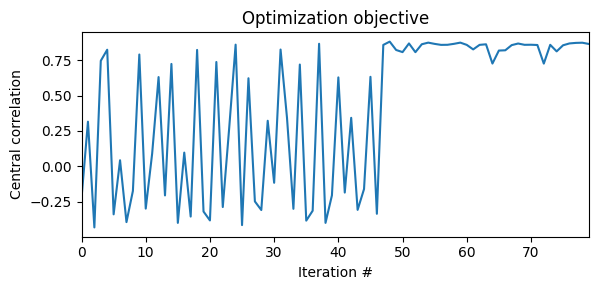

In [13]:
outputs.plot_optimization_objective();

### Visualize results

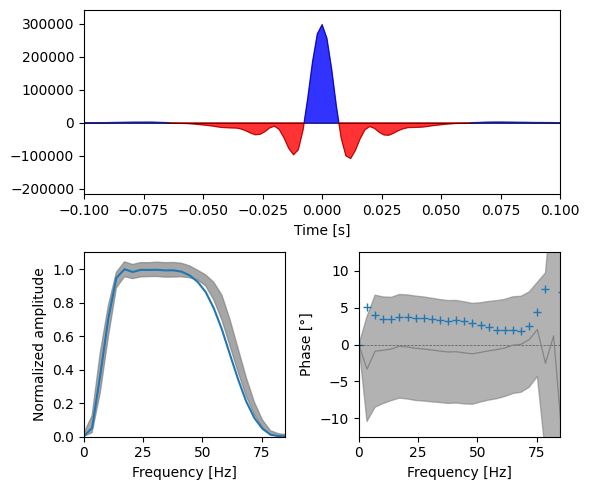

In [14]:
fig, axes = outputs.plot_wavelet(fmax=85, phi_max=15, figsize=(6,5))
axes[0].set_xlim((-0.1,0.1))
axes[2].set_ylim((-12.5,12.5))
fig.tight_layout()

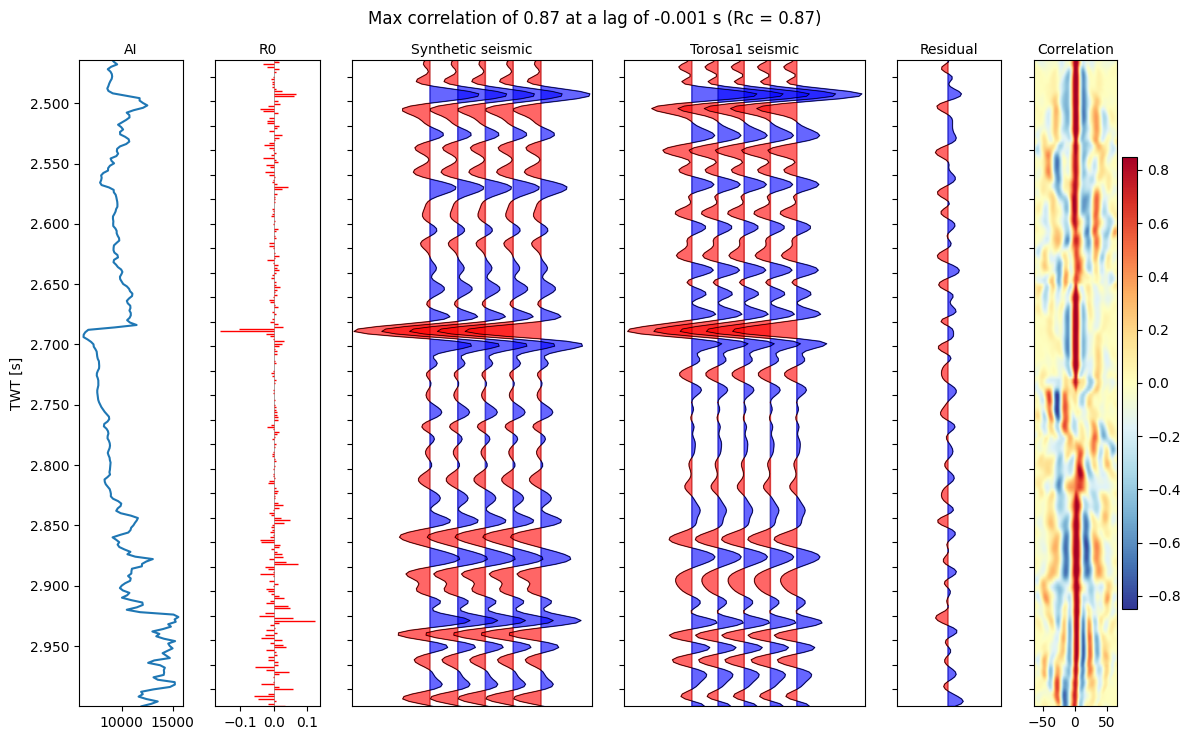

In [15]:
_scale = 120000
fig, axes = outputs.plot_tie_window(wiggle_scale=_scale, figsize=(12.,7.5))

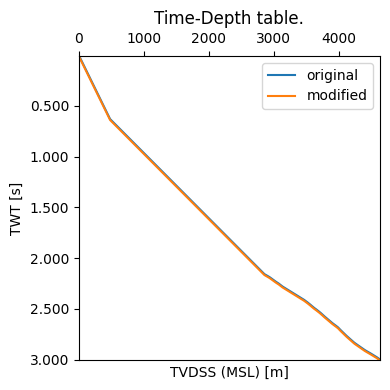

In [16]:
fig,ax = viz.plot_td_table(inputs.table, plot_params=dict(label='original'))
viz.plot_td_table(outputs.table,  plot_params=dict(label='modified'), fig_axes=(fig,ax))
ax.legend(loc='best')

#### Test automatic Stretch & Squeeze

In [17]:
s_and_s_params = dict(window_length=0.060, max_lag=0.010) # in seconds

outputs2 = autotie.stretch_and_squeeze(inputs,
                                       outputs,
                                       wavelet_extractor,
                                       modeler,
                                       wavelet_scaling_params,
                                       best_parameters,
                                       s_and_s_params)

upper
[3550.83469487 3628.99298706 3725.16021015 3504.21740849 3392.29102451
 3506.53491509 3563.74967941 3569.98480966 3546.74434631 3501.46262557
 3468.67879544 3442.77652839 3401.30584201 3448.14877342 3613.08354849
 4095.06344704 4540.29367792 4505.66916991 4637.57481203 4803.82880434
 4638.82597805 4333.05511915 4104.9013305  4190.14162365 4186.48782025
 4055.16471856 3915.79621712 3782.90809971 3897.17809481 3970.19716583
 3852.23079242 3864.00242831 4049.46134534 4165.21216819 4178.50674792
 4068.95764199 3852.23501381 3746.66508805 3731.76369445 3777.24747281
 3712.10833639 3517.48777484 3568.61200663 3653.56835953 3510.11133237
 3450.24539922 3442.38455657 3284.55057049 3204.86897276 3225.2472689
 3168.33585998 3212.2257949  3447.35119601 3568.3548444  3565.78444087
 3620.95574151 3647.91739801 3667.37461358 3689.37972209 3695.24208645
 3695.97540799 3643.58624428 3626.31987511 3600.68660313 3542.30559196
 3544.02914751 3541.77818147 3550.12104963 3547.52847294 3540.97711524
 

100%|██████████| 60/60 [00:02<00:00, 20.54it/s] 
[WARNING 02-14 15:07:02] ax.adapter.cross_validation: Metric scaling_loss was unable to be reliably fit.
[WARNING 02-14 15:07:02] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 02-14 15:07:02] ax.service.utils.best_point: Model fit is poor and data on objective metric scaling_loss is noisy; interpret best points results carefully.


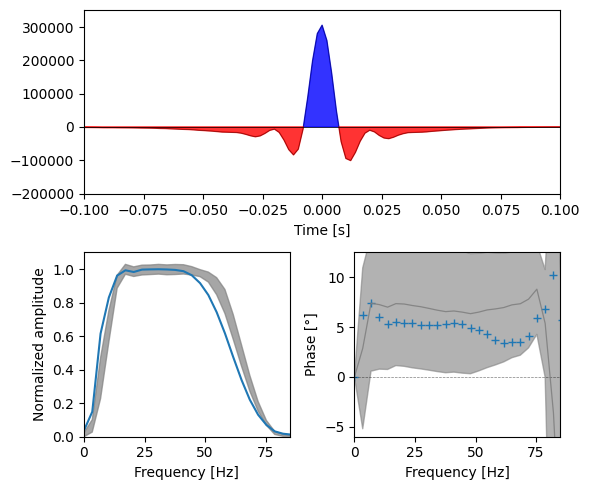

In [18]:
fig, axes = outputs2.plot_wavelet(fmax=85, phi_max=25, figsize=(6,5))
axes[0].set_xlim((-0.1,0.1))
axes[2].set_ylim((-6.,12.5))
fig.tight_layout()

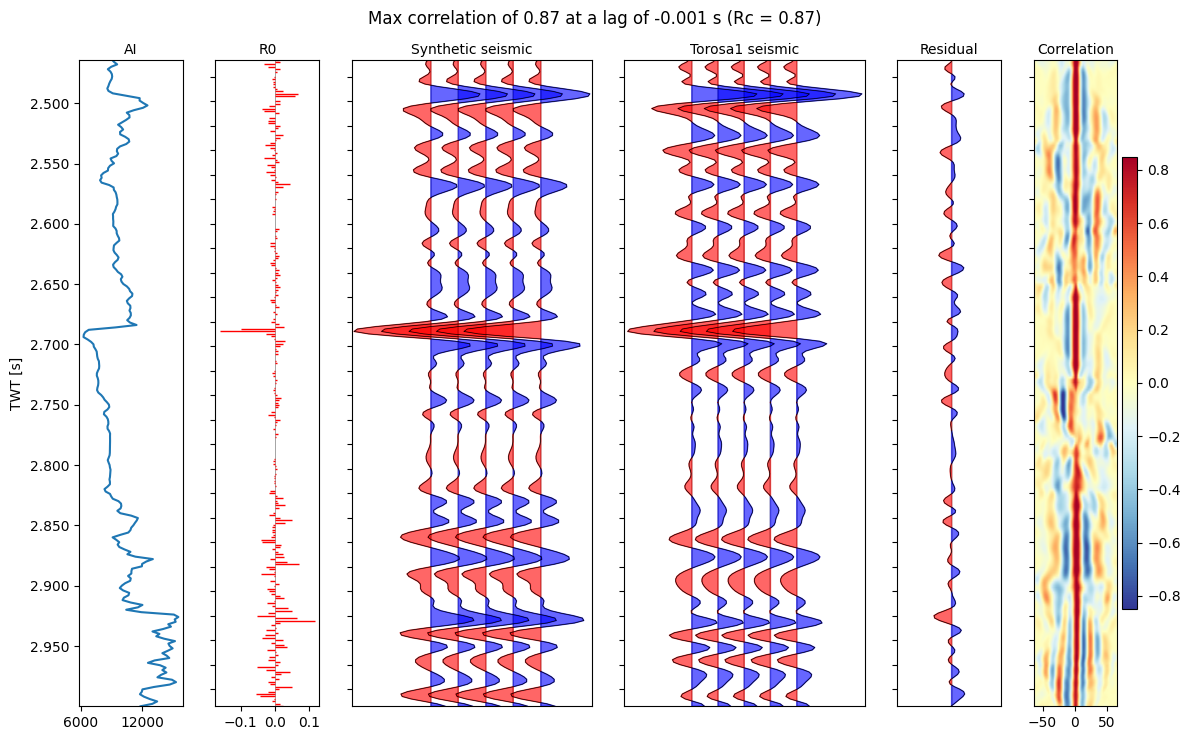

In [19]:
fig, axes = outputs2.plot_tie_window(wiggle_scale=_scale, figsize=(12.,7.5));
from matplotlib.ticker import MaxNLocator
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=2))

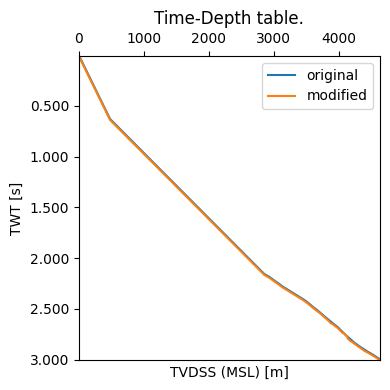

In [20]:
fig,ax = viz.plot_td_table(inputs.table, plot_params=dict(label='original'))
viz.plot_td_table(outputs2.table,  plot_params=dict(label='modified'), fig_axes=(fig,ax))
ax.legend(loc='best')

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

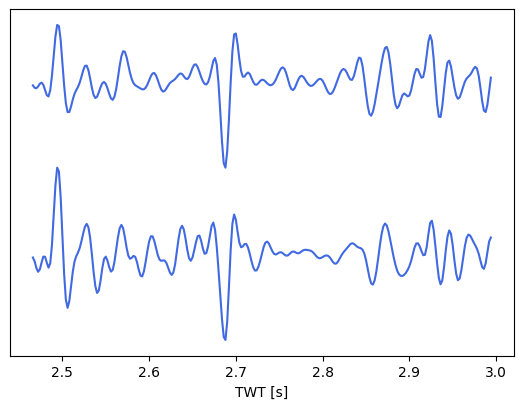

In [21]:
fig, ax = viz.plot_warping(outputs.synth_seismic, outputs.seismic, outputs2.dlags)